# Imports

In [ ]:
import os
import subprocess
import re 
import json
from pathlib import Path
from collections import defaultdict
from IPython.display import display, Image

import pandas as pd

# Notebook Setup

In [ ]:
# Start from the notebook's current working directory
HERE = Path.cwd().resolve()

# Walk upwards until we find the repo root (has both "ml" and "data")
REPO_ROOT = None
for p in [HERE] + list(HERE.parents):
    if (p / "ml").exists() and (p / "data").exists():
        REPO_ROOT = p
        break

if REPO_ROOT is None:
    raise RuntimeError(f"[x] Couldn't find repo root from {HERE}. Expected folders 'ml/' and 'data/'.")

os.chdir(REPO_ROOT)
print("[*] Notebook cwd:", HERE)
print("[*] Repo root:", REPO_ROOT)
print("[*] Now cwd:", Path.cwd())

# Inputs
MERGED_PARQUET = "data/datasets/cicids2017_multiclass_zeek_ebpf.parquet"

# Split config
SPLIT_PROTOCOL = os.environ.get("SPLIT_PROTOCOL", "stratified_label")
SPLIT_SEED = int(os.environ.get("SPLIT_SEED", "42"))
TRAIN_FRAC = float(os.environ.get("TRAIN_FRAC", "0.70"))
VAL_FRAC = float(os.environ.get("VAL_FRAC", "0.15"))
TEST_FRAC = float(os.environ.get("TEST_FRAC", "0.15"))
MIN_CLASS_COUNT = int(os.environ.get("MIN_CLASS_COUNT", "10"))

# Derived paths
ZEEK_ONLY_PARQUET = "data/datasets/cicids2017_multiclass_zeek_only.parquet"
ZEEK_EBPF_PARQUET = "data/datasets/cicids2017_multiclass_zeek_plus_ebpf.parquet"

BASE_SPLITS_DIR = f"data/datasets/splits_{SPLIT_PROTOCOL}_seed{SPLIT_SEED}"
SPLITS_BASELINE = f"{BASE_SPLITS_DIR}/zeek_only_primary"
SPLITS_EBPF = f"{BASE_SPLITS_DIR}/zeek_plus_ebpf_primary"

REPORTS_DIR = Path("data/reports")
MODELS_DIR = Path("data/models")
FEATURE_IMPORTANCE_DIR = Path(f"data/reports/feature_importance/{SPLIT_PROTOCOL}_seed{SPLIT_SEED}")


print("[*] MERGED_PARQUET:", MERGED_PARQUET)
print("[*] Split protocol:", SPLIT_PROTOCOL)
print("[*] Split seed:", SPLIT_SEED)
print("[*] Fractions:", TRAIN_FRAC, VAL_FRAC, TEST_FRAC)
print("[*] Split out baseline:", SPLITS_BASELINE)
print("[*] Split out ebpf:", SPLITS_EBPF)

[*] Notebook cwd: /mnt/c/Users/merin/Documents/GitHub/ebpf-net-sentinel/ml/notebooks
[*] Repo root: /mnt/c/Users/merin/Documents/GitHub/ebpf-net-sentinel
[*] Now cwd: /mnt/c/Users/merin/Documents/GitHub/ebpf-net-sentinel
[*] MERGED_PARQUET: data/datasets/cicids2017_multiclass_zeek_ebpf.parquet
[*] Split protocol: stratified_label
[*] Split seed: 42
[*] Fractions: 0.7 0.15 0.15
[*] Split out baseline: data/datasets/splits_stratified_label_seed42/zeek_only_primary
[*] Split out ebpf: data/datasets/splits_stratified_label_seed42/zeek_plus_ebpf_primary


In [ ]:
p = Path(MERGED_PARQUET)
assert p.exists(), f"Missing merged parquet: {MERGED_PARQUET}"

MODELS_DIR.mkdir(parents=True, exist_ok=True)
REPORTS_DIR.mkdir(parents=True, exist_ok=True)
FEATURE_IMPORTANCE_DIR.mkdir(parents=True, exist_ok=True)

Path(SPLITS_BASELINE).mkdir(parents=True, exist_ok=True)
Path(SPLITS_EBPF).mkdir(parents=True, exist_ok=True)

print("[*] All paths exist")

[*] All paths exist


# Dataset Preparation

In [4]:
subprocess.run(
    ["python3", "ml/data_prep/make_datasets.py",
     "--in_parquet", MERGED_PARQUET,
     "--out_baseline", "data/datasets/cicids2017_multiclass_zeek_only.parquet",
     "--out_enhanced", "data/datasets/cicids2017_multiclass_zeek_plus_ebpf.parquet",
     "--report_dir", "data/reports/make_datasets"],
    check=True
)

[*] Wrote:
   data/datasets/cicids2017_multiclass_zeek_only.parquet
   data/datasets/cicids2017_multiclass_zeek_plus_ebpf.parquet
[*] Report:
   data/reports/make_datasets/dataset_build_report.json


CompletedProcess(args=['python3', 'ml/data_prep/make_datasets.py', '--in_parquet', 'data/datasets/cicids2017_multiclass_zeek_ebpf.parquet', '--out_baseline', 'data/datasets/cicids2017_multiclass_zeek_only.parquet', '--out_enhanced', 'data/datasets/cicids2017_multiclass_zeek_plus_ebpf.parquet', '--report_dir', 'data/reports/make_datasets'], returncode=0)

In [5]:
subprocess.run(
    ["python3", "ml/data_prep/split_days_auto.py",
     "--in_parquet", ZEEK_ONLY_PARQUET,
     "--out_dir", SPLITS_BASELINE,
     "--protocol", SPLIT_PROTOCOL,
     "--seed", str(SPLIT_SEED),
     "--train_frac", str(TRAIN_FRAC),
     "--val_frac", str(VAL_FRAC),
     "--test_frac", str(TEST_FRAC),
     "--min_class_count", str(MIN_CLASS_COUNT)
    ],
    check=True
)

subprocess.run(
    ["python3", "ml/data_prep/split_days_auto.py",
     "--in_parquet", ZEEK_EBPF_PARQUET,
     "--out_dir", SPLITS_EBPF,
     "--protocol", SPLIT_PROTOCOL,
     "--seed", str(SPLIT_SEED),
     "--train_frac", str(TRAIN_FRAC),
     "--val_frac", str(VAL_FRAC),
     "--test_frac", str(TEST_FRAC),
     "--min_class_count", str(MIN_CLASS_COUNT)
    ],
    check=True
)

[*] Wrote splits to: data/datasets/splits_stratified_label_seed42/zeek_only_primary
  train: data/datasets/splits_stratified_label_seed42/zeek_only_primary/train.parquet
  val: data/datasets/splits_stratified_label_seed42/zeek_only_primary/val.parquet
  test: data/datasets/splits_stratified_label_seed42/zeek_only_primary/test.parquet
[*] split report: data/datasets/splits_stratified_label_seed42/zeek_only_primary/split_report.json
[*] Wrote splits to: data/datasets/splits_stratified_label_seed42/zeek_plus_ebpf_primary
  train: data/datasets/splits_stratified_label_seed42/zeek_plus_ebpf_primary/train.parquet
  val: data/datasets/splits_stratified_label_seed42/zeek_plus_ebpf_primary/val.parquet
  test: data/datasets/splits_stratified_label_seed42/zeek_plus_ebpf_primary/test.parquet
[*] split report: data/datasets/splits_stratified_label_seed42/zeek_plus_ebpf_primary/split_report.json


CompletedProcess(args=['python3', 'ml/data_prep/split_days_auto.py', '--in_parquet', 'data/datasets/cicids2017_multiclass_zeek_plus_ebpf.parquet', '--out_dir', 'data/datasets/splits_stratified_label_seed42/zeek_plus_ebpf_primary', '--protocol', 'stratified_label', '--seed', '42', '--train_frac', '0.7', '--val_frac', '0.15', '--test_frac', '0.15', '--min_class_count', '10'], returncode=0)

In [6]:
def label_coverage(splits_dir: str):
    splits_dir = Path(splits_dir)
    for split in ["train", "val", "test"]:
        df = pd.read_parquet(splits_dir / f"{split}.parquet")
        label_col = "label_family" if "label_family" in df.columns else None
        print(f"\n[*] {splits_dir.name} / {split}")
        print("rows:", len(df))
        if "is_attack" in df.columns:
            print("is_attack:\n", df["is_attack"].value_counts(dropna=False).to_string())
        if label_col:
            vc = df[label_col].fillna("Unknown").astype(str).value_counts()
            print("labels present:", list(vc.index))
            print(vc.head(30).to_string())
        else:
            print("[!] No label_family column found. Columns:", list(df.columns)[:30])

print("\n[*] BASELINE SPLITS:")
label_coverage(SPLITS_BASELINE)

print("\n[*] EBPF SPLITS:")
label_coverage(SPLITS_EBPF)


[*] BASELINE SPLITS:

[*] zeek_only_primary / train
rows: 1480665
is_attack:
 is_attack
0    1167420
1     313245
labels present: ['BENIGN', 'DoS', 'PortScan', 'DDoS', 'BruteForce', 'Bot', 'WebAttack', 'Infiltration']
label_family
BENIGN          1167420
DoS              133486
PortScan         111372
DDoS              60702
BruteForce         4838
Bot                1569
WebAttack          1263
Infiltration         15

[*] zeek_only_primary / val
rows: 317285
is_attack:
 is_attack
0    250569
1     66716
labels present: ['BENIGN', 'DoS', 'PortScan', 'DDoS', 'BruteForce', 'Bot', 'WebAttack', 'Heartbleed', 'Infiltration']
label_family
BENIGN          250569
DoS              28375
PortScan         23851
DDoS             12815
BruteForce        1085
Bot                298
WebAttack          290
Heartbleed           1
Infiltration         1

[*] zeek_only_primary / test
rows: 317286
is_attack:
 is_attack
0    249889
1     67397
labels present: ['BENIGN', 'DoS', 'PortScan', 'DDoS', 'BruteF

# Training and Evaluation

## Baseline Model (Zeek-only)

In [7]:
run_name = f"baseline_if_{SPLIT_PROTOCOL}_seed{SPLIT_SEED}"

subprocess.run(
    ["python3", "ml/methods/unsupervised_iforest/train_iforest.py",
     "--splits_dir", SPLITS_BASELINE,
     "--run_name", run_name,
     "--out_models_dir", "data/models",
     "--out_reports_dir", "data/reports",
     "--contamination", "0.1",
     "--n_estimators", "100"
    ],
    check=True
)

# Record the latest completed run for the notebook UI
(Path("data/reports") / "_latest_run.txt").write_text(run_name + "\n")
print("[*] latest run:", run_name)

[*] Training set: 1480665 samples
  BENIGN: 1167420 (78.8%)
  ATTACK: 313245 (21.2%)
[*] Validation set: 317285 samples
  BENIGN: 250569 (79.0%)
  ATTACK: 66716 (21.0%)
[*] Test set: 317286 samples
  BENIGN: 249889 (78.8%)
  ATTACK: 67397 (21.2%)

Using 10 numeric features:
  duration, orig_p, resp_p, orig_bytes, resp_bytes, orig_pkts, resp_pkts, src_port, dst_port, proto_i...

Training on BENIGN samples only: 1167420

[*] Training Isolation Forest...

[*] VALIDATION METRICS:
  accuracy: 0.7383
  precision: 0.2565
  recall: 0.1288
  f1: 0.1715
  roc_auc: 0.7591

[*] TEST METRICS:
  accuracy: 0.7371
  precision: 0.2634
  recall: 0.1322
  f1: 0.1761
  roc_auc: 0.7595

[*] PER-ATTACK DETECTION (TEST):
  Bot            :  142/ 341 ( 41.6%)
  BruteForce     :    3/1042 (  0.3%)
  DDoS           : 1882/13119 ( 14.3%)
  DoS            :  189/28721 (  0.7%)
  Infiltration   :    2/   6 ( 33.3%)
  PortScan       : 6679/23886 ( 28.0%)
  WebAttack      :   15/ 282 (  5.3%)

[*] Saved model: data/

In [8]:
run_name = f"baseline_rf_{SPLIT_PROTOCOL}_seed{SPLIT_SEED}"

subprocess.run(
    ["python3", "ml/methods/supervised_rf/train_random_forest.py",
     "--splits_dir", SPLITS_BASELINE,
     "--run_name", run_name,
     "--out_models_dir", "data/models",
     "--out_reports_dir", "data/reports",
     "--n_estimators", "200",
     "--max_depth", "20",
     "--balance_classes"
    ],
    check=True
)

# Record the latest completed run for the notebook UI
(Path("data/reports") / "_latest_run.txt").write_text(run_name + "\n")
print("[*] latest run:", run_name)

[*] Random Forest: baseline_rf_stratified_label_seed42

Train: 1,480,665 (313,245 attacks)
Val:   317,285 (66,716 attacks)
Test:  317,286 (67,397 attacks)
Features: 10

[*] Training Random Forest (n=200, depth=20)...
[*] Training completed in 63.2s
[*] VALIDATION METRICS:
  accuracy    : 0.9910
  precision   : 0.9626
  recall      : 0.9959
  f1          : 0.9790
  roc_auc     : 0.9996
[*] TEST METRICS:
  accuracy    : 0.9913
  precision   : 0.9642
  recall      : 0.9958
  f1          : 0.9798
  roc_auc     : 0.9997
[*] PER-ATTACK DETECTION:
  Bot            :   340/   341 (99.7%)
  BruteForce     :  1042/  1042 (100.0%)
  DDoS           : 13115/ 13119 (100.0%)
  DoS            : 28710/ 28721 (100.0%)
  Infiltration   :     3/     6 (50.0%)
  PortScan       : 23871/ 23886 (99.9%)
  WebAttack      :    35/   282 (12.4%)

[*] Top 10 Features:
  proto_i                       : 0.1724
  dst_port                      : 0.1422
  orig_bytes                    : 0.1421
  resp_pkts              

## Enhanced Model (Zeek + eBPF)

In [9]:
run_name = f"ebpf_if_{SPLIT_PROTOCOL}_seed{SPLIT_SEED}"

subprocess.run(
    ["python3", "ml/methods/unsupervised_iforest/train_iforest.py",
     "--splits_dir", SPLITS_EBPF,
     "--run_name", run_name,
     "--out_models_dir", "data/models",
     "--out_reports_dir", "data/reports",
     "--contamination", "0.1",
     "--n_estimators", "100"
    ],
    check=True
)

# Record the latest completed run for the notebook UI
(Path("data/reports") / "_latest_run.txt").write_text(run_name + "\n")
print("[*] latest run:", run_name)

[*] Training set: 1480665 samples
  BENIGN: 1167420 (78.8%)
  ATTACK: 313245 (21.2%)
[*] Validation set: 317285 samples
  BENIGN: 250569 (79.0%)
  ATTACK: 66716 (21.0%)
[*] Test set: 317286 samples
  BENIGN: 249889 (78.8%)
  ATTACK: 67397 (21.2%)
[*] Dropping all-NaN columns: ['ebpf_comm']

Using 17 numeric features:
  duration, orig_p, resp_p, orig_bytes, resp_bytes, orig_pkts, resp_pkts, src_port, dst_port, proto_i...

Training on BENIGN samples only: 1167420

[*] Training Isolation Forest...

[*] VALIDATION METRICS:
  accuracy: 0.7482
  precision: 0.3210
  recall: 0.1772
  f1: 0.2284
  roc_auc: 0.7957

[*] TEST METRICS:
  accuracy: 0.7469
  precision: 0.3253
  recall: 0.1784
  f1: 0.2304
  roc_auc: 0.7963

[*] PER-ATTACK DETECTION (TEST):
  Bot            :  141/ 341 ( 41.3%)
  BruteForce     :   71/1042 (  6.8%)
  DDoS           : 1196/13119 (  9.1%)
  DoS            : 4542/28721 ( 15.8%)
  Infiltration   :    3/   6 ( 50.0%)
  PortScan       : 6056/23886 ( 25.4%)
  WebAttack      

In [10]:
run_name = f"ebpf_rf_{SPLIT_PROTOCOL}_seed{SPLIT_SEED}"

subprocess.run(
    ["python3", "ml/methods/supervised_rf/train_random_forest.py",
     "--splits_dir", SPLITS_EBPF,
     "--run_name", run_name,
     "--out_models_dir", "data/models",
     "--out_reports_dir", "data/reports",
     "--n_estimators", "200",
     "--max_depth", "20",
     "--balance_classes"
    ],
    check=True
)

# Record the latest completed run for the notebook UI
(Path("data/reports") / "_latest_run.txt").write_text(run_name + "\n")
print("[*] latest run:", run_name)

[*] Random Forest: ebpf_rf_stratified_label_seed42

Train: 1,480,665 (313,245 attacks)
Val:   317,285 (66,716 attacks)
Test:  317,286 (67,397 attacks)
Features: 18

[*] Training Random Forest (n=200, depth=20)...
[*] Training completed in 61.3s
[*] VALIDATION METRICS:
  accuracy    : 0.9941
  precision   : 0.9761
  recall      : 0.9965
  f1          : 0.9862
  roc_auc     : 0.9998
[*] TEST METRICS:
  accuracy    : 0.9942
  precision   : 0.9770
  recall      : 0.9963
  f1          : 0.9866
  roc_auc     : 0.9998
[*] PER-ATTACK DETECTION:
  Bot            :   339/   341 (99.4%)
  BruteForce     :  1042/  1042 (100.0%)
  DDoS           : 13118/ 13119 (100.0%)
  DoS            : 28714/ 28721 (100.0%)
  Infiltration   :     3/     6 (50.0%)
  PortScan       : 23883/ 23886 (100.0%)
  WebAttack      :    49/   282 (17.4%)

[*] Top 10 Features:
  proto_i                       : 0.1372
  dst_port                      : 0.1332
  resp_p                        : 0.1185
  orig_bytes                

# Compare Baseline vs Enhanced Results

In [11]:
subprocess.run(
    ["python3", "ml/analysis/statistical_comparison.py",
     "--baseline_summary", f"data/reports/baseline_if_{SPLIT_PROTOCOL}_seed{SPLIT_SEED}_iforest_summary.json",
     "--ebpf_summary", f"data/reports/ebpf_if_{SPLIT_PROTOCOL}_seed{SPLIT_SEED}_iforest_summary.json",
     "--out_json", f"data/reports/comparison_if_{SPLIT_PROTOCOL}_seed{SPLIT_SEED}.json"
    ],
    check=True
)

subprocess.run(
    ["python3", "ml/analysis/statistical_comparison.py",
     "--baseline_summary", f"data/reports/baseline_rf_{SPLIT_PROTOCOL}_seed{SPLIT_SEED}_rf_summary.json",
     "--ebpf_summary", f"data/reports/ebpf_rf_{SPLIT_PROTOCOL}_seed{SPLIT_SEED}_rf_summary.json",
     "--out_json", f"data/reports/comparison_rf_{SPLIT_PROTOCOL}_seed{SPLIT_SEED}.json"
    ],
    check=True
)

[*] STATISTICAL COMPARISON: Baseline vs eBPF-Enhanced
[*] SUMMARY

[*] Detailed comparison saved: data/reports/comparison_if_stratified_label_seed42.json
[*] STATISTICAL COMPARISON: Baseline vs eBPF-Enhanced
[*] SUMMARY

[*] Detailed comparison saved: data/reports/comparison_rf_stratified_label_seed42.json


CompletedProcess(args=['python3', 'ml/analysis/statistical_comparison.py', '--baseline_summary', 'data/reports/baseline_rf_stratified_label_seed42_rf_summary.json', '--ebpf_summary', 'data/reports/ebpf_rf_stratified_label_seed42_rf_summary.json', '--out_json', 'data/reports/comparison_rf_stratified_label_seed42.json'], returncode=0)

In [12]:
subprocess.run(
     ["python3", "ml/analysis/analyze_feature_importance.py",
      "--model_baseline", f"data/models/baseline_rf_{SPLIT_PROTOCOL}_seed{SPLIT_SEED}_rf.joblib",
      "--model_ebpf", f"data/models/ebpf_rf_{SPLIT_PROTOCOL}_seed{SPLIT_SEED}_rf.joblib",
      "--test_data_baseline", f"{SPLITS_BASELINE}/test.parquet",
      "--test_data_ebpf", f"{SPLITS_EBPF}/test.parquet",
      "--out_dir", f"data/reports/feature_importance/{SPLIT_PROTOCOL}_seed{SPLIT_SEED}",
      "--n_repeats", "10",
      "--top_k", "20"
     ],
     check=True
)

[*] Summary saved: data/reports/feature_importance/stratified_label_seed42/feature_importance_summary.json
[*] Plots saved in: data/reports/feature_importance/stratified_label_seed42


CompletedProcess(args=['python3', 'ml/analysis/analyze_feature_importance.py', '--model_baseline', 'data/models/baseline_rf_stratified_label_seed42_rf.joblib', '--model_ebpf', 'data/models/ebpf_rf_stratified_label_seed42_rf.joblib', '--test_data_baseline', 'data/datasets/splits_stratified_label_seed42/zeek_only_primary/test.parquet', '--test_data_ebpf', 'data/datasets/splits_stratified_label_seed42/zeek_plus_ebpf_primary/test.parquet', '--out_dir', 'data/reports/feature_importance/stratified_label_seed42', '--n_repeats', '10', '--top_k', '20'], returncode=0)

# View plots for the current run

[*] Auto-selected current run: `ebpf_rf_stratified_label_seed42`
[*] Run: `ebpf_rf_stratified_label_seed42`
[*] Reports dir: /mnt/c/Users/merin/Documents/GitHub/ebpf-net-sentinel/data/reports
[*] `ebpf_rf_stratified_label_seed42_rf_summary.json`
{
  "timestamp": "2026-02-20T12:56:29.421791Z",
  "run_name": "ebpf_rf_stratified_label_seed42",
  "model": "RandomForest",
  "params": {
    "n_estimators": 200,
    "max_depth": 20,
    "class_weight": "balanced"
  },
  "training_time_seconds": 61.288240909576416,
  "features": [
    "duration",
    "orig_p",
    "resp_p",
    "orig_bytes",
    "resp_bytes",
    "orig_pkts",
    "resp_pkts",
    "src_port",
    "dst_port",
    "proto_i",
    "ebpf_bytes_sent",
    "ebpf_bytes_recv",
    "ebpf_retransmits",
    "ebpf_state_changes",
    "ebpf_samples",
    "ebpf_pid",
    "ebpf_uid",
    "ebpf_comm"
  ],
  "validation": {
    "accuracy": 0.9941283073577383,
    "precision": 0.9760971384104891,
    "recall": 0.9964776065711374,
    "f1": 0.9861

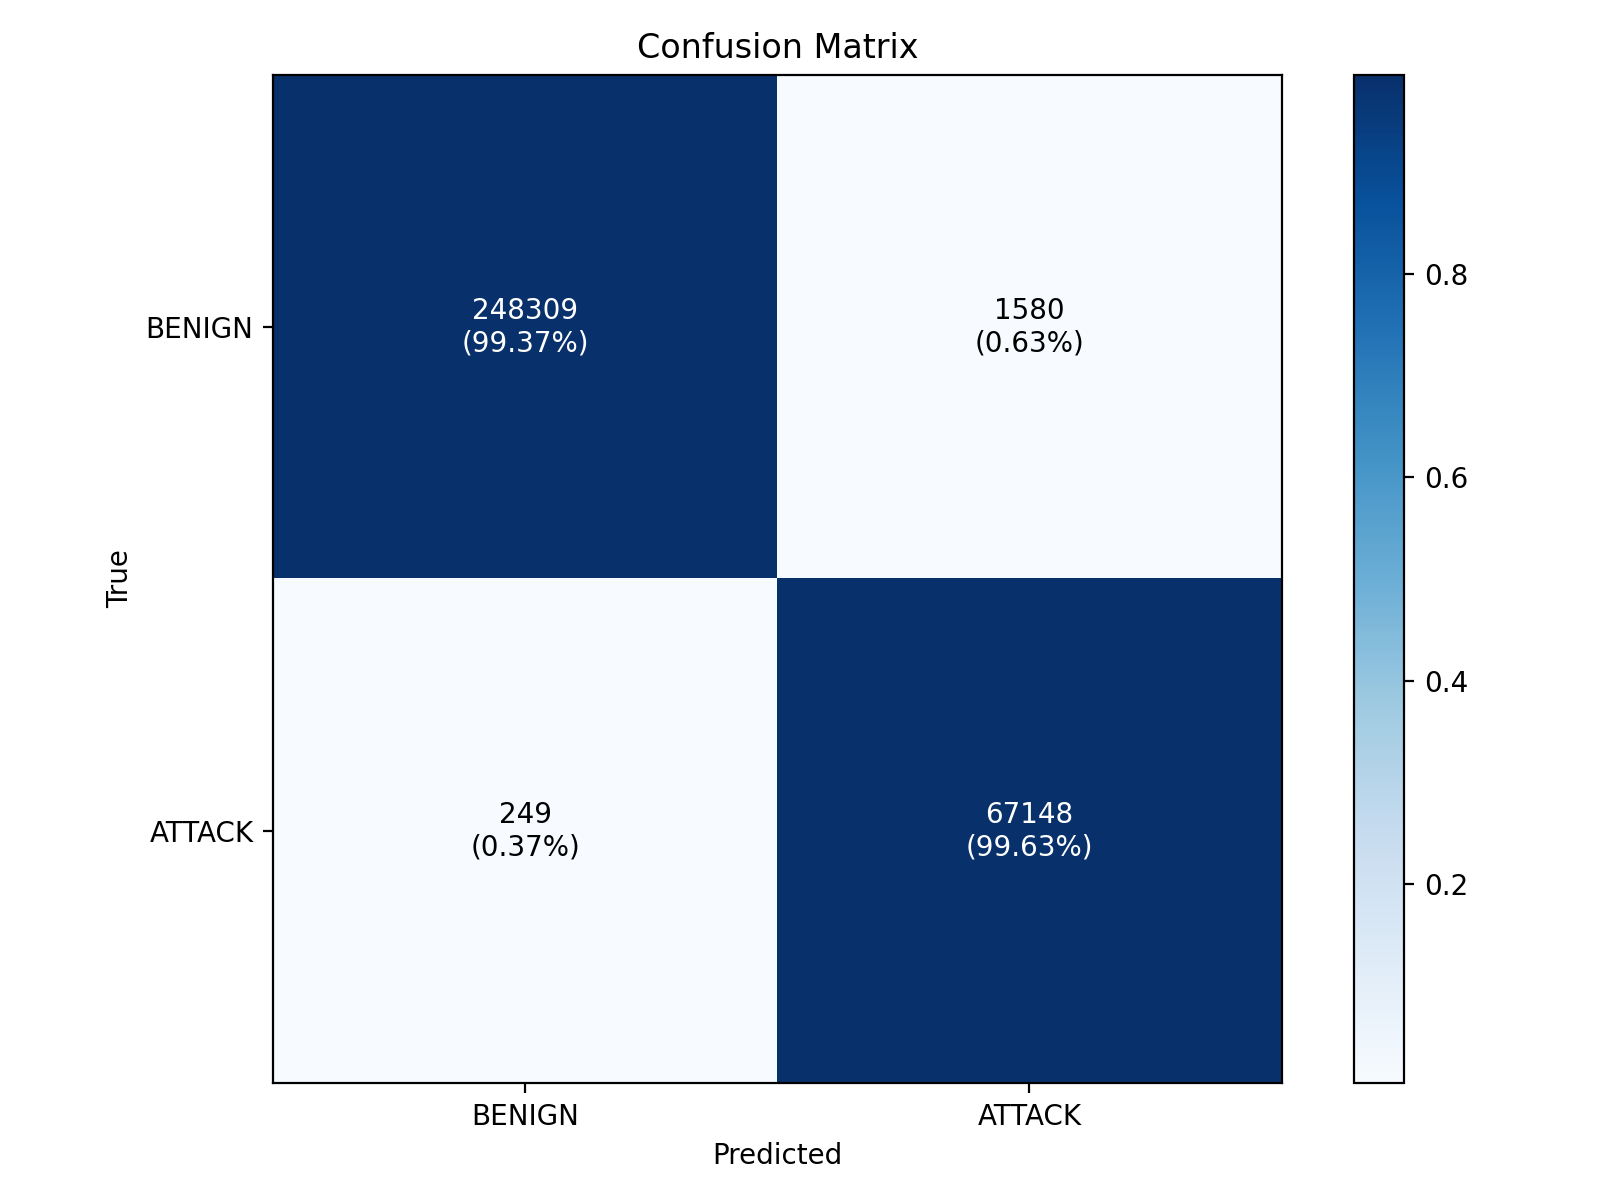

In [ ]:
REPORTS_DIR = Path("data/reports")

def _infer_run_name_from_file(fname: str) -> str | None:
    # Highest confidence artifact
    if fname.endswith("_metrics_summary.json"):
        return fname[:-len("_metrics_summary.json")]

    # Common saved artifacts from training
    for suf, pat in [
        ("_confusion.png", r"_([A-Za-z0-9\-]+)_confusion\.png$"),
        ("_classification_report.txt", r"_([A-Za-z0-9\-]+)_classification_report\.txt$"),
        ("_iforest_summary.json", r"_iforest_summary\.json$"),  # run_name_iforest_summary.json
        ("_rf_summary.json", r"_rf_summary\.json$"),            # run_name_rf_summary.json
    ]:
        if fname.endswith(suf):
            return re.sub(pat, "", fname)

    # Fallback: for <run_name>_<something>.png assume first token is run_name-ish
    if fname.endswith(".png") and "_" in fname:
        return fname.split("_")[0]

    return None

def pick_current_run_name(reports_dir: Path = REPORTS_DIR) -> str:
    """
    Picks the 'current' run in this order:
      1) data/reports/_latest_run.txt (written by notebook after each train cell)
      2) newest artifact mtime across known run artifacts in data/reports/
    """
    latest_file = reports_dir / "_latest_run.txt"
    if latest_file.exists():
        rn = latest_file.read_text().strip()
        if rn:
            return rn

    patterns = [
        "*_metrics_summary.json",
        "*_iforest_summary.json",
        "*_rf_summary.json",
        "*_confusion.png",
        "*_classification_report.txt",
        "*.png",
    ]
    files = []
    for pat in patterns:
        files.extend(reports_dir.glob(pat))
    if not files:
        raise RuntimeError(f"[x] No report artifacts found in {reports_dir}")

    run_to_mtimes = defaultdict(list)
    for p in files:
        rn = _infer_run_name_from_file(p.name)
        if rn:
            run_to_mtimes[rn].append(p.stat().st_mtime)

    if not run_to_mtimes:
        raise RuntimeError("[!] Found report files, but couldn't infer any run_name from filenames.")

    latest_run, _ = max(((rn, max(mts)) for rn, mts in run_to_mtimes.items()), key=lambda x: x[1])
    return latest_run

def show_run_outputs(run_name: str, max_images: int = 40):
    print(f"[*] Run: `{run_name}`")
    print(f"[*] Reports dir: {REPORTS_DIR.resolve()}")

    # Summary json(s)
    summary_candidates = [
        REPORTS_DIR / f"{run_name}_metrics_summary.json",
        REPORTS_DIR / f"{run_name}_iforest_summary.json",
        REPORTS_DIR / f"{run_name}_rf_summary.json",
    ]
    for s in summary_candidates:
        if s.exists():
            print(f"[*] `{s.name}`")
            try:
                data = json.loads(s.read_text())
                # pretty-ish print without dumping huge blobs
                print(json.dumps(data, indent=2)[:8000])
            except Exception:
                print(s.read_text()[:8000])
            print()

    # Text reports
    txts = sorted(REPORTS_DIR.glob(f"{run_name}_*_classification_report.txt"))
    if txts:
        print("[*] Classification reports")
        for p in txts:
            print(f"[*] {p.name}")
            print(p.read_text()[:8000])
            print("\n" + "-"*80 + "\n")

    # Images/plots
    pngs = sorted(REPORTS_DIR.glob(f"{run_name}_*.png"))
    if pngs:
        print("[*] Plots")
        for p in pngs[:max_images]:
            print(f"[*] {p.name}")
            display(Image(filename=str(p)))
        if len(pngs) > max_images:
            print(f"... {len(pngs)-max_images} more images not shown (increase max_images).")
    else:
        print("[!] No PNG plots found for this run in `data/reports/`.")

def show_current_run(max_images: int = 40):
    rn = pick_current_run_name()
    print(f"[*] Auto-selected current run: `{rn}`")
    show_run_outputs(rn, max_images=max_images)

show_current_run()

In [14]:
print("[*] Models:")
for p in sorted(Path("data/models").glob(f"*_{SPLIT_PROTOCOL}_seed{SPLIT_SEED}_*.joblib")):
    print(" ", p)

print("\n[*] Reports:")
for p in sorted(Path("data/reports").glob(f"*_{SPLIT_PROTOCOL}_seed{SPLIT_SEED}_*.json")):
    print(" ", p)

print("\n[*] Feature importance dir:", FEATURE_IMPORTANCE_DIR)

[*] Models:
  data/models/baseline_if_stratified_label_seed42_iforest.joblib
  data/models/baseline_rf_stratified_label_seed42_rf.joblib
  data/models/ebpf_if_stratified_label_seed42_iforest.joblib
  data/models/ebpf_rf_stratified_label_seed42_rf.joblib

[*] Reports:
  data/reports/baseline_if_stratified_label_seed42_iforest_summary.json
  data/reports/baseline_rf_stratified_label_seed42_rf_summary.json
  data/reports/ebpf_if_stratified_label_seed42_iforest_summary.json
  data/reports/ebpf_rf_stratified_label_seed42_rf_summary.json

[*] Feature importance dir: data/reports/feature_importance/stratified_label_seed42
